##Conexion

In [1]:
!pip install PyDrive
!pip install --upgrade category_encoders

     |████████████████████████████████| 80 kB 3.3 MB/s 


In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
from google.colab import files

In [5]:
id_train_labels = '1o8fEed65R8219m5iOJoZgvHXaTGwWE4H'
id_train_values = "1RCoa3FWbpcHVC6imhaQQFQEAWNW0qkh0" 
id_test_values = '1xBGPZbt3BYxe1OOYGMJuGnXe_pEqFZ1a'
id_submission_format = "1ei8BhsAAhZpZ8sRqEOVGl12y0JAPdXGV"


downloaded_train_labels = drive.CreateFile({'id': id_train_labels})
downloaded_train_values = drive.CreateFile({'id': id_train_values})
downloaded_test_values = drive.CreateFile({'id': id_test_values})
downloaded_submission_format = drive.CreateFile({'id': id_submission_format})

In [6]:

downloaded_train_labels.GetContentFile('train_labels.csv')
downloaded_train_values.GetContentFile('train_values.csv')
downloaded_test_values.GetContentFile('test_values.csv')
downloaded_submission_format.GetContentFile('submission_format.csv')


In [7]:

train_values = pd.read_csv('train_values.csv', dtype={
    'building_id': 'int64', 'geo_level_1_id': 'int64',
    'geo_level_2_id': 'int64', 'geo_level_3_id': 'int64',
    'count_floors_pre_eq': 'int8', 'age': 'int32',
    'area_percentage': 'int32', 'height_percentage': 'int32',
    'land_surface_condition': 'category', 'foundation_type': 'category',
    'roof_type': 'category', 'ground_floor_type': 'category', 'other_floor_type': 'category',
    'position': 'category', 'plan_configuration': 'category', 'has_superstructure_adobe_mud': 'int8',
    'has_superstructure_mud_mortar_stone': 'int8', 'has_superstructure_stone_flag': 'int8',
    'has_superstructure_cement_mortar_stone': 'int8', 'has_superstructure_mud_mortar_brick': 'int8',
    'has_superstructure_cement_mortar_brick': 'int8', 'has_superstructure_timber': 'int8',
    'has_superstructure_bamboo': 'int8', 'has_superstructure_rc_non_engineered': 'int8',
    'has_superstructure_rc_engineered': 'int8', 'has_superstructure_other': 'int8',
    'has_superstructure_other': 'int8', 'legal_ownership_status': 'category',
    'has_secondary_use': 'bool', 'has_secondary_use_agriculture': 'bool',
    'has_secondary_use_hotel': 'bool', 'has_secondary_use_rental': 'bool',
    'has_secondary_use_institution': 'bool', 'has_secondary_use_school': 'bool',
    'has_secondary_use_industry': 'bool', 'has_secondary_use_health_post': 'bool',
    'has_secondary_use_gov_office': 'bool', 'has_secondary_use_use_police': 'bool',
    'has_secondary_use_other': 'bool', 'count_families': 'int8'
})
train_labels = pd.read_csv('train_labels.csv', dtype={
    'damage_grade': 'int16'
})

test_values = pd.read_csv('test_values.csv', dtype={
  'building_id': 'int64', 'geo_level_1_id': 'int64',
    'geo_level_2_id': 'int64', 'geo_level_3_id': 'int64',
    'count_floors_pre_eq': 'int8', 'age': 'int32',
    'area_percentage': 'int32', 'height_percentage': 'int32',
    'land_surface_condition': 'category', 'foundation_type': 'category',
    'roof_type': 'category', 'ground_floor_type': 'category', 'other_floor_type': 'category',
    'position': 'category', 'plan_configuration': 'category', 'has_superstructure_adobe_mud': 'int8',
    'has_superstructure_mud_mortar_stone': 'int8', 'has_superstructure_stone_flag': 'int8',
    'has_superstructure_cement_mortar_stone': 'int8', 'has_superstructure_mud_mortar_brick': 'int8',
    'has_superstructure_cement_mortar_brick': 'int8', 'has_superstructure_timber': 'int8',
    'has_superstructure_bamboo': 'int8', 'has_superstructure_rc_non_engineered': 'int8',
    'has_superstructure_rc_engineered': 'int8', 'has_superstructure_other': 'int8',
    'has_superstructure_other': 'int8', 'legal_ownership_status': 'category',
    'has_secondary_use': 'bool', 'has_secondary_use_agriculture': 'bool',
    'has_secondary_use_hotel': 'bool', 'has_secondary_use_rental': 'bool',
    'has_secondary_use_institution': 'bool', 'has_secondary_use_school': 'bool',
    'has_secondary_use_industry': 'bool', 'has_secondary_use_health_post': 'bool',
    'has_secondary_use_gov_office': 'bool', 'has_secondary_use_use_police': 'bool',
    'has_secondary_use_other': 'bool', 'count_families': 'int8'
})

)


In [8]:
a = 'geo_level_1_id	geo_level_2_id	geo_level_3_id	count_floors_pre_eq	age	area_percentage	height_percentage	land_surface_condition	foundation_type	roof_type	ground_floor_type	other_floor_type	position	plan_configuration	has_superstructure_adobe_mud	has_superstructure_mud_mortar_stone	has_superstructure_stone_flag	has_superstructure_cement_mortar_stone	has_superstructure_mud_mortar_brick	has_superstructure_cement_mortar_brick	has_superstructure_timber	has_superstructure_bamboo	has_superstructure_rc_non_engineered	has_superstructure_rc_engineered	has_superstructure_other	legal_ownership_status	count_families	has_secondary_use	has_secondary_use_agriculture	has_secondary_use_hotel	has_secondary_use_rental	has_secondary_use_institution	has_secondary_use_school	has_secondary_use_industry	has_secondary_use_health_post	has_secondary_use_gov_office	has_secondary_use_use_police	has_secondary_use_other'
a.split()

['geo_level_1_id',
 'geo_level_2_id',
 'geo_level_3_id',
 'count_floors_pre_eq',
 'age',
 'area_percentage',
 'height_percentage',
 'land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'has_superstructure_adobe_mud',
 'has_superstructure_mud_mortar_stone',
 'has_superstructure_stone_flag',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_mud_mortar_brick',
 'has_superstructure_cement_mortar_brick',
 'has_superstructure_timber',
 'has_superstructure_bamboo',
 'has_superstructure_rc_non_engineered',
 'has_superstructure_rc_engineered',
 'has_superstructure_other',
 'legal_ownership_status',
 'count_families',
 'has_secondary_use',
 'has_secondary_use_agriculture',
 'has_secondary_use_hotel',
 'has_secondary_use_rental',
 'has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_industry',
 'has_secondary_use_health_post',
 'has_secondary_use_gov_office',
 'has_sec

In [9]:
train_values

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,n,r,n,f,j,s,q,0,1,0,0,0,0,0,0,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False
260597,669485,17,715,2060,2,0,6,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False
260598,602512,17,51,8163,3,55,6,7,t,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False
260599,151409,26,39,1851,2,10,14,6,t,r,x,v,s,j,d,0,0,0,0,0,1,0,0,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False


In [10]:
labels_and_values = pd.merge(
    train_labels, train_values, how='inner', on='building_id')

In [11]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(objective='multiclass', random_state=5)


##Filtrando Data Set

In [12]:
labels_and_values = labels_and_values[labels_and_values['age']!=995]

In [13]:
damage_prediction = labels_and_values['damage_grade']

In [14]:
labels_and_values

,building_id,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,3,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False
1,28830,2,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False
2,94947,3,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False
3,590882,2,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False
4,201944,3,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,2,25,1335,1621,1,55,6,3,n,r,n,f,j,s,q,0,1,0,0,0,0,0,0,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False
260597,669485,3,17,715,2060,2,0,6,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False
260598,602512,3,17,51,8163,3,55,6,7,t,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False
260599,151409,2,26,39,1851,2,10,14,6,t,r,x,v,s,j,d,0,0,0,0,0,1,0,0,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False


In [15]:
features = labels_and_values[[ 'geo_level_1_id',
 'geo_level_2_id',
 'geo_level_3_id',
 'count_floors_pre_eq',
 'age',
 'area_percentage',
 'height_percentage',
 'land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'legal_ownership_status',
 'count_families',
 ]]

In [16]:
test_values = test_values[[ 'geo_level_1_id',
 'geo_level_2_id',
 'geo_level_3_id',
 'count_floors_pre_eq',
 'age',
 'area_percentage',
 'height_percentage',
 'land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'legal_ownership_status',
 'count_families',
 ]]

##Creacion del Set de Entrenamiento y Test

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, damage_prediction, test_size=0.2, random_state=45)

##LGBM

In [29]:
from lightgbm import LGBMClassifier as lgb
import matplotlib.pyplot as plt

#0.7391 precision
"""lgbm = lgbm = LGBMClassifier(        objective="multiclass",
        num_class=3,
        metric="multi_error",
        boosting= 'gbdt',
        max_depth= 22,
        num_leaves= 117,
        n_estimators= 113,
        learning_rate=  0.43,
        feature_fraction= 0.5,
        min_sum_hessian_in_leaf= 0.1,
        max_bin=8192,
        verbosity= 1,
        num_threads=6,
        seed= 1881)"""

#0.7332
#lgbm = LGBMClassifier(objective='multiclass', random_state=5, max_depth=15, colsample_bytree=0.63, learning_rate= 0.2, n_estimators= 150, num_leaves= 100, reg_alpha= 1.2, reg_lambda= 1)

#0.7379
#lgbm = LGBMClassifier(objective='multiclass', random_state=5, max_depth=19, colsample_bytree=0.63, learning_rate= 0.3, n_estimators= 150, num_leaves= 120, reg_alpha= 1.2, reg_lambda= 1)

#0.7380
#lgbm = LGBMClassifier(objective='multiclass', random_state=5, max_depth=25, colsample_bytree=0.63, learning_rate= 0.4, n_estimators= 130, num_leaves= 110, reg_alpha= 1.2, reg_lambda= 1)

#0.7382
#lgbm = LGBMClassifier(objective='multiclass', random_state=5, max_depth=18, colsample_bytree=0.65, learning_rate= 0.5, n_estimators= 145, num_leaves= 130, reg_alpha= 1.2, reg_lambda= 1)

lgbm = lgbm = LGBMClassifier(        objective="multiclass",
        num_class=3,
        metric="multi_error",
        boosting= 'gbdt',
        max_depth= 22,
        num_leaves= 117,
        n_estimators= 113,
        learning_rate=  0.43,
        feature_fraction= 0.5,
        min_sum_hessian_in_leaf= 0.1,
        max_bin=8192,
        verbosity= 1,
        num_threads=6,
        seed= 1881)
lgbm.fit(X_train, y_train)

LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.43, max_bin=8192,
               max_depth=22, metric='multi_error', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0,
               min_sum_hessian_in_leaf=0.1, n_estimators=113, n_jobs=-1,
               num_class=3, num_leaves=117, num_threads=6,
               objective='multiclass', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, seed=1881, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbosity=1)

In [30]:
predicciones = lgbm.predict(X_test)

In [31]:
f1_score(predicciones, y_test, average='micro')

0.7381517273305943

In [32]:
cm=confusion_matrix(y_test,predicciones)

In [33]:
cm

array([[ 2589,  2376,    77],
       [ 1103, 24874,  3364],
       [  115,  6540, 10805]])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text major ticklabel objects>)

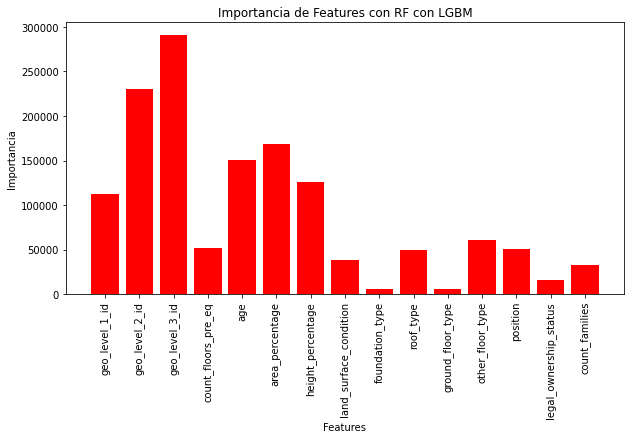

In [21]:

plt.subplots(figsize=(10,5))
plt.bar(X_train.columns, lgbm.feature_importances_, color = 'red')
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia de Features con RF con LGBM')
plt.xticks(rotation=90)

#plt.show() 

##GridSearch

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [23]:
"""gridParams = {
    'learning_rate': [0.42],
    'n_estimators': [110,115,120],
    'max_deph':[19,21,23],
    'num_leaves': [105,110,115,120], # 
    'colsample_bytree' : [0.60, 0.63],
    }
    
## GridSearch con K-Fold Cross Validation
grid = GridSearchCV(lgbm, gridParams, objective='multiclass',feature_fraction=0.5,num_class=3, verbose=1, cv=3, n_jobs=-1,num_threads=6)
# Run the grid
grid.fit(train_values_features, damage_prediction)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)"""

"gridParams = {\n    'learning_rate': [0.42],\n    'n_estimators': [110,115,120],\n    'max_deph':[19,21,23],\n    'num_leaves': [105,110,115,120], # \n    'colsample_bytree' : [0.60, 0.63],\n    }\n    \n## GridSearch con K-Fold Cross Validation\ngrid = GridSearchCV(lgbm, gridParams, objective='multiclass',feature_fraction=0.5,num_class=3, verbose=1, cv=3, n_jobs=-1,num_threads=6)\n# Run the grid\ngrid.fit(train_values_features, damage_prediction)\n\n# Print the best parameters found\nprint(grid.best_params_)\nprint(grid.best_score_)"

##Submission

In [34]:
pred_train = lgbm.predict(test_values)

In [35]:
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')

In [36]:
my_submission = pd.DataFrame(data=pred_train,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [37]:
my_submission.to_csv('submission.csv')

In [38]:
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>